In [1]:
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras import Sequential

plt.rcParams.update({'font.size': 22})
tfd = tfp.distributions

In [2]:
def create_dataset(n, x_range):
    x_uniform_dist = tfd.Uniform(low=x_range[0], high=x_range[1])
    x = x_uniform_dist.sample(n).numpy() [:, np.newaxis] 
    y_true = 2.7*x+3
    eps_uniform_dist = tfd.Normal(loc=0, scale=1)
    eps = eps_uniform_dist.sample(n).numpy() [:, np.newaxis] *0.74*x
    y = y_true + eps
    return x, y, y_true

In [3]:
x_train, y_train, y_true = create_dataset(200, [-10, 10])
x_val, y_val, _ = create_dataset(50, [-10, 10])

In [4]:
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  c = np.log(np.expm1(1.))
  return Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
                     scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1)),
  ])



In [5]:
def prior_trainable(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  return Sequential([
      tfp.layers.VariableLayer(n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t, scale=1),
          reinterpreted_batch_ndims=1)),
  ])

In [6]:
negloglik = lambda y, rv_y: -rv_y.log_prob(y)

In [7]:
# Build model.
model = Sequential([
  tfp.layers.DenseVariational(1, posterior_mean_field, prior_trainable, kl_weight=1/x_train.shape[0]),
  tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)),
])

# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(x_train, y_train, epochs=100, verbose=1)


Epoch 1/100
7/7 [==============================] - 2s 5ms/step - loss: 105.9423
Epoch 2/100
7/7 [==============================] - 0s 4ms/step - loss: 95.3668
Epoch 3/100
7/7 [==============================] - 0s 4ms/step - loss: 165.2451
Epoch 4/100
7/7 [==============================] - 0s 3ms/step - loss: 84.6878
Epoch 5/100
7/7 [==============================] - 0s 4ms/step - loss: 107.3117
Epoch 6/100
7/7 [==============================] - 0s 6ms/step - loss: 148.8506
Epoch 7/100
7/7 [==============================] - 0s 4ms/step - loss: 82.9009
Epoch 8/100
7/7 [==============================] - 0s 6ms/step - loss: 124.3439
Epoch 9/100
7/7 [==============================] - 0s 4ms/step - loss: 86.7174
Epoch 10/100
7/7 [==============================] - 0s 6ms/step - loss: 114.4306
Epoch 11/100
7/7 [==============================] - 0s 3ms/step - loss: 86.0139
Epoch 12/100
7/7 [==============================] - 0s 7ms/step - loss: 101.8409
Epoch 13/100
7/7 [========================

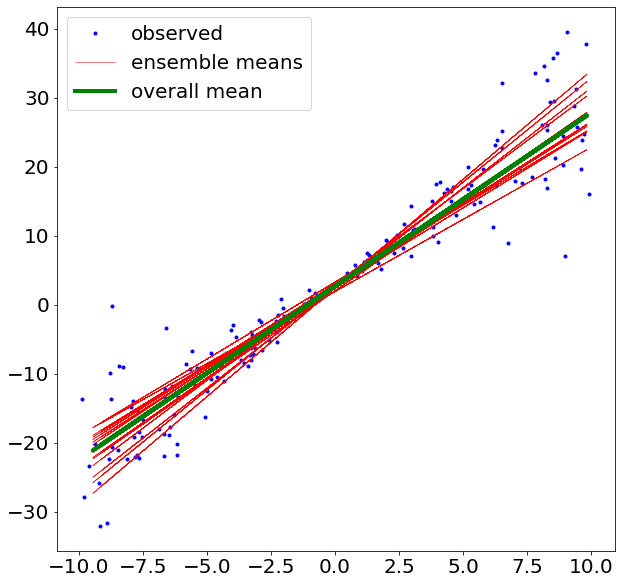

In [8]:
x_range = [-10, 10]
plt.figure(figsize=[10, 10]) 
plt.clf();
plt.plot(x_train, y_train, 'b.', label='observed');

y_preds = [model(x_val) for _ in range(100)]
avgm = np.zeros_like(x_val[..., 0])
for i, yhat in enumerate(y_preds):
  m = np.squeeze(yhat.mean())
  s = np.squeeze(yhat.stddev())
  if i < 15:
    plt.plot(x_val, m, 'r', label='ensemble means' if i == 0 else None, linewidth=0.5)
  avgm += m
plt.plot(x_val, avgm/len(y_preds), 'g', label='overall mean', linewidth=4)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc='upper left', prop={'size': 20})